#  Scalable K-Means++

# Background

K-means has been one the the most popular clustering algorithm. The method is used to divide the data set into k clusters. Starting from a set of randomly chosen initial points, the algorithm assign them to nearest centers and then updating new centers according to these new points. Thus, this is a iterative process. K-means method is popular and scalable due to its simple iterative nature. However, the running time is exponential in worst case and the final result may be local optimum, not global optimum.

To solve these problems, recent researches try to improving initial assignment. K-means++ is such an improved algorithm that finds proper initialization points. Downside of this algorithm is that it is still sequential process which total running time of $O(nkd)$, which limits its efficiency in massive datasets cases.

The paper Scalable k-means++ proposes a parallel version of the k-means++ algorithm that has total running time $O(logn)$. In this project, I will implement this algorithm that is called k-means||. The algorithm achieves higher efficiency through lowering number of iterations needed for convergence and selecting more than one point in each iteration.

## Implementation

### Notations

Let $X =\{x_1,...x_n\}$ be the set of points in $d$-dimensional Euclidean space and let $k$ be a positive integer specifying the number of clusters. Let ||$x_i$ - $x_j$ || denote the Euclidean distance between $x_i$ and $x_j$. For a point $x$ and a subset $Y \subseteq X$ of points, the distance is defined as $d(x,Y) = min_{y \in Y} ||x - y||$. For a subset $Y \subseteq X$ of points, let its $centroid$ be given by
\begin{equation*}
\begin{split}
    \text{centroid}(Y) = \frac{1}{|Y|}\sum_{y \in Y} y
\end{split}
\end{equation*}
Let $C =\{c_1,...c_k\}$ be the set of points and let $Y \subseteq X$. We define the $cost$ of $Y$ with respect to $C$ as
\begin{equation*}
\begin{split}
    \phi_Y(C) = \sum_{y \in Y} d^2(y,C) = \sum_{y \in Y} \min_{i=1,...,k}||y-c_i||^2
\end{split}
\end{equation*}


### Psuedocode: $k$-means|| ($k,l$) initialization
1. $C \leftarrow$ sample a point uniformly at random from $X$ 
2. $\psi \leftarrow \phi_X(C)$
3. **for** $O$(log$\psi$) times **do**
  - $C' \leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l \cdot d^2(x,C)}{\phi_X(C)}$	
  - $C \leftarrow C \cup C'$ 
4. **end for** 
5. For $x \in C$, set $w_x$ to be the number of points in $X$ closer to $x$ than any point in $C$ 
6. Recluster the weighted points in $C$ into $k$ clusters

### Algorithm

In [1]:
import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline
plt.style.use('ggplot')

#### Naive Version

In [2]:
def Cost(c, data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

def Prob(c,data,l):
    cost = Cost(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])  


def KMeansNaive(data, k, l):
    N = len(data)
    # 1. Random sample a point
    C = np.array(data[np.random.choice(range(N),1),])
    
    # 2. Compute phi = cost
    phi = Cost(C, data)

    # 3-6. For loop
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[Prob(C, data, l) > np.random.uniform(size = N),]
        C = np.concatenate((C, cPrime))
    
    # 7. Compute weight
    closest = [np.argmin(np.sum((C-pts)**2,axis=1)) for pts in data];
    wx = [closest.count(i) for i in range(len(C))]
    weight = wx/np.sum(wx)
    
    # 8. Recluster
    newC = data[np.random.choice(range(len(C)),size=1,p=weight),]
    newdata = C
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight
        newcPrime = data[np.random.choice(range(len(C)), size=1, p=Probability/np.sum(Probability)),]
        newC = np.concatenate((newC,newcPrime))
    # Finish k-means|| initialization
    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

#### Vectorized Version

In [3]:
def KMeansVector(data, k, l):
    N = len(data)
    # 1. Random sample a point
    c = data[np.random.choice(range(data.shape[0]),1), :]
    tempdata = data[:,np.newaxis,:]
    
    # 2. Compute phi = cost
    phi = Cost(c, data)
    
    # 3-6. For loop
    for j in range(np.ceil(np.log(phi)).astype(int)):
        dist = (tempdata - c) ** 2
        distance = np.sum(dist, axis=2)
        closest = np.zeros(distance.shape)
        closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        min_dist = distance[closest == 1]
        phi = np.sum(min_dist)
        # updating set of C
        for i, cPrime in enumerate(data):
            Probability = l*min_dist[i]/phi
            u = np.random.uniform(0,1)
            if Probability >= u:
                c = np.vstack([c, cPrime])
    
    # 7. Compute weight
    dist = (tempdata - c) ** 2
    distance = np.sum(dist, axis=2)
    closest = np.zeros(distance.shape)
    closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    weight = np.array([np.count_nonzero(closest[:, i]) for i in range(c.shape[0])]).reshape(-1,1)

    
    # 8. Recluster
    newC = c[np.random.choice(range(c.shape[0]), 1), ]
    newdata = c
    # delete chosen center
    index = np.where(newdata==newC)[0]
    newdata = np.delete(newdata,index[0],axis=0)
    weight = np.delete(weight,index[0])
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight 
        prob = Probability / np.sum(Probability)
        # choose next centroid
        c = newdata[np.random.choice(range(newdata.shape[0]),size=1, p=prob),]
        index = np.where(newdata==c)[0]
        newC = np.vstack([newC, c])
        newdata = np.delete(newdata,index[0],axis=0)
        weight = np.delete(weight,index[0])
    # Finish k-means|| initialization
    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

## Application and Comparison

### Generate data from 3 bivariate normal distribution

\begin{eqnarray*}
\begin{pmatrix}x_{1}\\
x_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
0\\
0
\end{array}\right),\left(\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right)\right]\\
\begin{pmatrix}y_{1}\\
y_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
6\\
2
\end{array}\right),\left(\begin{array}{ccc}
1 & 0.5\\
0.5 & 2
\end{array}\right)\right]\\
\begin{pmatrix}z_{1}\\
z_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
-4\\
4
\end{array}\right),\left(\begin{array}{ccc}
3 & 1\\
1 & 2
\end{array}\right)\right]\\
\end{eqnarray*}



In [4]:
def Samples(n):
    mean1 = np.array([0, 0])
    var1 = np.array([[1, 0], [0, 1]])
    
    mean2 = np.array([6, 2])
    var2 = np.array([[1, 0.5], [0.5, 2]])
    
    mean3 = np.array([-4, 4])
    var3 = np.array([[3, 1], [1, 2]])
    
    data = np.vstack((np.random.multivariate_normal(mean1, var1, n),
                      np.random.multivariate_normal(mean2, var2, n),
                      np.random.multivariate_normal(mean3, var3, n)))
    data = np.random.permutation(data)
    return data
data=Samples(10000)

### Application

#### Naive version

In [5]:
% timeit KMeansNaive(data,3,6)

1 loops, best of 3: 31.5 s per loop


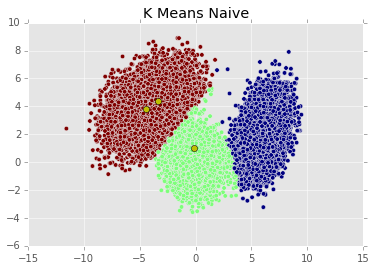

In [6]:
import sklearn.cluster
dfdata=pd.DataFrame(data,columns=["X","Y"])
KMeansN = KMeansNaive(data,3,6)
KMeansN.fit(data)
plt.scatter(dfdata.X, dfdata.Y,c=KMeansN.labels_);
plt.plot(KMeansN.init[:,0],KMeansN.init[:,1],"yo")
plt.title("K Means Naive");

#### Vectorized Version

In [7]:
% timeit KMeansVector(data,3,6)

1 loops, best of 3: 3.96 s per loop


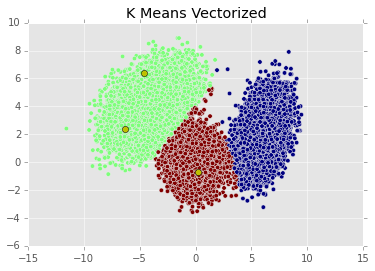

In [8]:
KMeansV = KMeansVector(data,3,6)
KMeansV.fit(data)
plt.scatter(dfdata.X, dfdata.Y,c=KMeansV.labels_);
plt.plot(KMeansV.init[:,0],KMeansV.init[:,1],"yo");
plt.title("K Means Vectorized");

### Comparison

#### Comparison with usual k-means

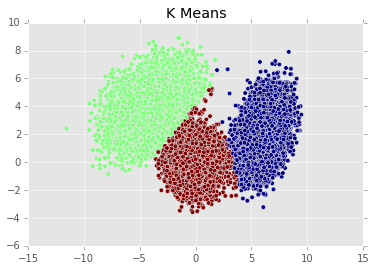

In [12]:
KMeans = sklearn.cluster.KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeans.fit(dfdata)
plt.scatter(dfdata.X, dfdata.Y,c=KMeans.labels_);
plt.title("K Means");


In [13]:
%timeit KMeans.fit(dfdata)

1 loops, best of 3: 243 ms per loop


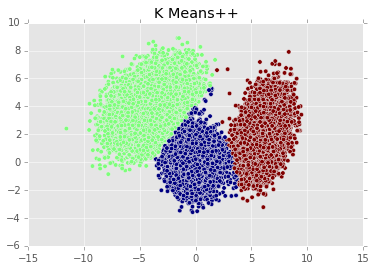

In [15]:
KMeansPP = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, tol=0.0001)
KMeansPP.fit(dfdata)
plt.scatter(dfdata.X, dfdata.Y,c=KMeansPP.labels_);
plt.title("K Means++");

In [16]:
%timeit KMeansPP.fit(dfdata)

1 loops, best of 3: 189 ms per loop


Given the same data set, initial settings, I campare the efficiency using diffrent algorithms.

Comparing the functions I wrote, vectorized version is significantly faster than naive version . However, both of them are much slower than sklearn.cluster.KMeans() function. I think if I can implement the functions in C and do more parallelization, the efficiency can be improved dramatically, since in theory, k-means|| has higher efficiency than either k-menas++ or k-means.

For the package function sklearn.cluster.KMeans() with different initialization methods, k-means++ is clearly faster than starting with a random number.

## Unit Code Tests

In [17]:
%%file costfunction.py

import numpy as np

def Cost(c, data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

Overwriting costfunction.py


In [18]:
%%file test_costfunction.py

import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost

def test_non_negativity():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert Cost(c, data) >= 0

def test_coincidence_when_zero():
    data = np.random.normal(size=(20,2))
    c = data
    assert Cost(c, data) == 0

def test_coincidence_when_not_zero():
     for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),19),]
        assert Cost(c, data) != 0


Overwriting test_costfunction.py


In [19]:
%%file probability.py


from costfunction import Cost
import numpy as np

def Prob(c,data,l):
    cost = Cost(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])  


Overwriting probability.py


In [20]:
%%file test_probability.py

import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost
from probability import Prob

def test_non_negativity():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert np.alltrue(Prob(c, data, 1) >= 0)

def test_sum():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert_almost_equal(np.sum(Prob(c, data, 1)),1)
        

Overwriting test_probability.py


In [21]:
%%file mainfunc.py
from __future__ import division
import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from costfunction import Cost
from probability import Prob


def KMeansNaive(data, k, l):
    N = len(data)
    # 1. Random sample a point
    C = np.array(data[np.random.choice(range(N),1),])
    # 2. Compute phi = cost
    phi = Cost(C, data)
    # 3-6. For loop
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[Prob(C, data, l) > np.random.uniform(size = N),]
        C = np.concatenate((C, cPrime))    
    # 7. Compute weight
    closest = [np.argmin(np.sum((C-pts)**2,axis=1)) for pts in data];
    wx = [closest.count(i) for i in range(len(C))]
    weight = wx/np.sum(wx)    
    # 8. Recluster
    newC = data[np.random.choice(range(len(C)),size=1,p=weight),]
    newdata = C
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight
        newcPrime = data[np.random.choice(range(len(C)), size=1, p=Probability/np.sum(Probability)),]
        newC = np.concatenate((newC,newcPrime))
    # Finish k-means|| initialization    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

Overwriting mainfunc.py


In [22]:
%%file test_mainfunc.py


import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost
from probability import Prob
from mainfunc import KMeansNaive

def test_klevels():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        k = 3
        assert len(set(KMeansNaive(data = data, k = k, l = 2*k).labels_)) == k

def test_len_labels():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        k = 3
        assert len(KMeansNaive(data = data, k = k, l = 2*k).labels_) == len(data)

Overwriting test_mainfunc.py


In [23]:
! py.test

============================= test session starts ==============================
platform darwin -- Python 2.7.9 -- py-1.4.26 -- pytest-2.6.4
collected 7 items 

test_costfunction.py ...
test_mainfunc.py ..
test_probability.py ..

=========================== 7 passed in 7.38 seconds ===========================


Unit tests for cost function contains 3 tests. The first one shows that cost must be non-negative. The latter two tests shows that cost = 0 if and only if c = data.

For probability function, I first test if all entries in the vector are non-negative. Then I test if the sum of probabilities is eual to 1.

For main function, I test the labels generated have correct clustering features: number of different labels = number of clusters, and number of total labels = number of data.